In [1]:
import experiment_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nds import ndomsort
import pygmo as pg
from sklearn.model_selection import train_test_split
import random

from moopt import monise
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting

import copy

In [45]:
data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
fair_feature = "not_white"
pred_feature = "Two_yr_Recidivism"

In [46]:
categories_fair_class = []

for index, row in data.iterrows():
    if row[pred_feature] == -1:
        categories_fair_class.append(row[fair_feature])
    else:
        categories_fair_class.append(row[fair_feature]+2)

random_gen = random.randint(0, 1000)
print(random_gen)

X = data.drop([pred_feature], axis=1)
y = data[pred_feature]

X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=int(data.shape[0]*0.2),stratify=categories_fair_class,
                                             random_state=random_gen)

ads = [categories_fair_class[i] for i in range(data.shape[0]) if i in X_tv.index.tolist()]
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=int(data.shape[0]*0.2),
                                                  stratify=ads, random_state=random_gen)

816


In [47]:
def nds_moo(models_df, n_selected = 10):
    models_df['EO'] = -models_df['EO']
    models_df['DP'] = -models_df['DP']
    if 'Acc' in models_df.columns:
        models_df['Acc'] = -models_df['Acc']
    metrics = models_df.values.tolist()

    fronts = ndomsort.non_domin_sort(metrics)
    selected_indexes = []
    for front in fronts:
        hv = pg.hypervolume([list(s) for s in fronts[front]])
        
        if len(selected_indexes)==n_selected:
            break
        
        if len(fronts[front])+len(selected_indexes)<n_selected:
            selected_indexes+=[metrics.index(seq) for seq in fronts[front]]
        else:
            last_front = list(copy.copy(fronts[front]))
            
            nadir = np.max(metrics,axis=0)
            nadir = nadir
            while len(last_front)>n_selected-len(selected_indexes):
                hv = pg.hypervolume([list(s) for s in last_front])
                idx_excl = hv.least_contributor(nadir)
                del last_front[idx_excl]
                
            selected_indexes += [metrics.index(seq) for seq in last_front]
            
    index_list = [models_df.index.tolist()[i] for i in selected_indexes]
    return index_list

In [48]:
results_test = pd.DataFrame(columns=['Approach', 'Acc', 'DP', 'EO', 'CV'])

In [49]:
## Train 150 models
moo_err = monise(weightedScalar=FairScalarization(X_train, y_train, fair_feature),
                singleScalar=FairScalarization(X_train, y_train, fair_feature),
                nodeTimeLimit=2, targetSize=150,
                targetGap=0, nodeGap=0.05, norm=False)

moo_err.optimize()

## Evaluate the models in val
mooerr_values = []
mooerr_sols = []

for solution in moo_err.solutionsList:
    mooerr_sols.append(solution.x)
    mooerr_values.append(experiment_utils.evaluate_model_test(solution.x, fair_feature, X_val, y_val))

mooerr_df = pd.DataFrame(mooerr_values)

2021-07-12 20:00:10,280 - moopt.monise - DEBUG: Finding 1th individual minima
2021-07-12 20:00:10,320 - moopt.monise - DEBUG: Finding 2th individual minima
2021-07-12 20:00:10,369 - moopt.monise - DEBUG: Finding 3th individual minima
2021-07-12 20:00:10,416 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2021-07-12 20:00:10,457 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-07-12 20:00:10,498 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-07-12 20:00:10,529 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-07-12 20:00:10,573 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-07-12 20:00:10,627 - moopt.monise - DEBUG: 9th solution - importance: 0.3401326549402492
2021-07-12 20:00:10,692 - moopt.monise - DEBUG: 10th solution - importance: 0.2910487332338438
2021-07-12 20:00:10,759 - moopt.monise - DEBUG: 11th solution - importance: 0.2830944001488902
2021-07-12 20:00:10,840 - moopt.monise - DEBUG: 12th solution - importance: 0.140123051

In [50]:
mooerr_df = pd.DataFrame(mooerr_values)

In [51]:
## Filter the 20 best models in Acc, then the 10 best in EO
index_list = list(mooerr_df.nlargest(20,'Acc').nlargest(10,'EO').index)
mooerr_filtered_models = [("Model "+str(i), mooerr_sols[i]) for i in index_list]

## Generate ensemble
ensemble_moo_err = SimpleVoting(estimators=mooerr_filtered_models, voting='soft', minimax=False)

# Evaluate
mooerr_metrics = experiment_utils.evaluate_model_test(ensemble_moo_err, fair_feature, X_test, y_test)
mooerr_metrics['Approach'] = 'MOOErr - EO'

results_test = results_test.append(mooerr_metrics, ignore_index=True)

In [52]:
index_list = nds_moo(mooerr_df.copy())
mooerr_filtered_models = [("Model "+str(i), mooerr_sols[i]) for i in index_list]

## Generate ensemble
ensemble_moo_err = SimpleVoting(estimators=mooerr_filtered_models, voting='soft', minimax=False)

# Evaluate
mooerr_metrics_nds = experiment_utils.evaluate_model_test(ensemble_moo_err, fair_feature, X_test, y_test)
mooerr_metrics_nds['Approach'] = 'MOOErr - NDS'

results_test = results_test.append(mooerr_metrics_nds, ignore_index=True)

In [53]:
models_acc = mooerr_df.copy().nlargest(20,'Acc')
models_acc = models_acc.drop(['Acc'], axis=1)

index_list = nds_moo(models_acc.copy())
mooerr_filtered_models = [("Model "+str(i), mooerr_sols[i]) for i in index_list]

## Generate ensemble
ensemble_moo_err = SimpleVoting(estimators=mooerr_filtered_models, voting='soft', minimax=False)

# Evaluate
mooerr_metrics_nds_noacc = experiment_utils.evaluate_model_test(ensemble_moo_err, fair_feature, X_test, y_test)
mooerr_metrics_nds_noacc['Approach'] = 'MOOErr - NDS - NoAcc'

results_test = results_test.append(mooerr_metrics_nds_noacc, ignore_index=True)

In [54]:
## Train 150 models
mooacep = monise(weightedScalar=EqualScalarization(X_train, y_train, fair_feature),
            singleScalar=EqualScalarization(X_train, y_train, fair_feature),
            nodeTimeLimit=2, targetSize=150,
            targetGap=0, nodeGap=0.01, norm=False)

mooacep.optimize()

## Evaluate the models in val
mooacc_values = []
mooacc_sols = []

for solution in mooacep.solutionsList:
    mooacc_sols.append(solution.x)
    mooacc_values.append(experiment_utils.evaluate_model_test(solution.x, fair_feature, X_val, y_val))

mooacep_df = pd.DataFrame(mooacc_values)

2021-07-12 20:02:22,552 - moopt.monise - DEBUG: Finding 1th individual minima
2021-07-12 20:02:22,617 - moopt.monise - DEBUG: Finding 2th individual minima
2021-07-12 20:02:22,657 - moopt.monise - DEBUG: Finding 3th individual minima
2021-07-12 20:02:22,696 - moopt.monise - DEBUG: Finding 4th individual minima
2021-07-12 20:02:22,834 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-07-12 20:02:22,955 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-07-12 20:02:23,074 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-07-12 20:02:23,166 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-07-12 20:02:23,234 - moopt.monise - DEBUG: 9th solution - importance: 1.0
2021-07-12 20:02:23,294 - moopt.monise - DEBUG: 10th solution - importance: 0.7029163514327995
2021-07-12 20:02:23,432 - moopt.monise - DEBUG: 11th solution - importance: 0.5903549506073588
2021-07-12 20:02:23,576 - moopt.monise - DEBUG: 12th solution - importance: 0.4727465614085373
2021-07-

In [55]:
## Filter the 20 best models in Acc, then the 10 best in EO
index_list = list(mooacep_df.nlargest(20,'Acc').nlargest(10,'EO').index)
mooacep_filtered_models = [("Model "+str(i), mooacc_sols[i]) for i in index_list]

## Generate ensemble
ensemble_moo_acep = SimpleVoting(estimators=mooacep_filtered_models, voting='soft', minimax=False)

# Evaluate
mooerr_metrics = experiment_utils.evaluate_model_test(ensemble_moo_acep, fair_feature, X_test, y_test)
mooerr_metrics['Approach'] = 'MOOAcep - EO'

results_test = results_test.append(mooerr_metrics, ignore_index=True)

In [56]:
index_list = nds_moo(mooacep_df.copy())
mooacep_filtered_models = [("Model "+str(i), mooacc_sols[i]) for i in index_list]

## Generate ensemble
ensemble_moo_acep = SimpleVoting(estimators=mooacep_filtered_models, voting='soft', minimax=False)

# Evaluate
mooerr_metrics_nds = experiment_utils.evaluate_model_test(ensemble_moo_acep, fair_feature, X_test, y_test)
mooerr_metrics_nds['Approach'] = 'MOOAcep - NDS'

results_test = results_test.append(mooerr_metrics_nds, ignore_index=True)

In [57]:
models_acc = mooacep_df.copy().nlargest(20,'Acc')
models_acc = models_acc.drop(['Acc'], axis=1)

index_list = nds_moo(models_acc.copy())
mooacep_filtered_models = [("Model "+str(i), mooacc_sols[i]) for i in index_list]

## Generate ensemble
ensemble_moo_acep = SimpleVoting(estimators=mooacep_filtered_models, voting='soft', minimax=False)

# Evaluate
mooerr_metrics_nds_noacc = experiment_utils.evaluate_model_test(ensemble_moo_acep, fair_feature, X_test, y_test)
mooerr_metrics_nds_noacc['Approach'] = 'MOOAcep - NDS - NoAcc'

results_test = results_test.append(mooerr_metrics_nds_noacc, ignore_index=True)

# Vis

In [58]:
results_test = results_test.set_index('Approach')

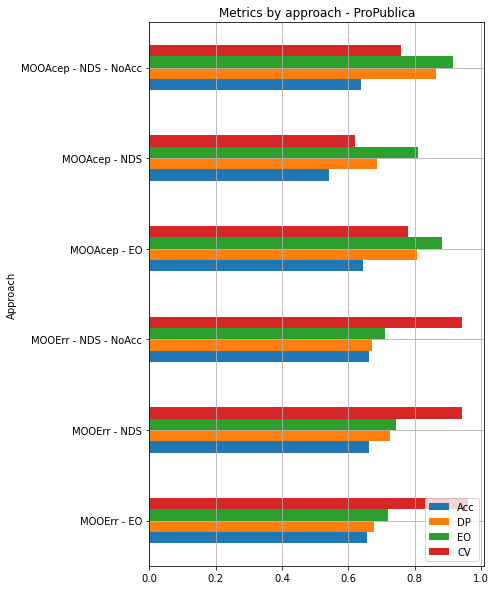

In [59]:
results_test.plot.barh(grid=True, figsize=(6,10))
plt.title('Metrics by approach - ProPublica')
plt.show()

In [60]:
results_test

,Acc,DP,EO,CV
Approach,,,,
MOOErr - EO,0.657212,0.677045,0.719203,0.961283
MOOErr - NDS,0.662075,0.724169,0.744142,0.941696
MOOErr - NDS - NoAcc,0.661264,0.672315,0.711998,0.942401
MOOAcep - EO,0.643436,0.806198,0.881511,0.781173
MOOAcep - NDS,0.541329,0.685117,0.811083,0.621257
MOOAcep - NDS - NoAcc,0.638574,0.865724,0.916997,0.757274
